# Text Analytics Group Assignment 1

This assignment has two parts, A and B. In A, you will perform some basic text mining tasks just to familiarize yourself with the nuances of putting text mining theories to practice with Python scripts. Part B involves building and testing classification models to predict salaries from the text contained in the job descriptions. The data for this assignment can be found at http://www.kaggle.com/c/job-salary-prediction


##Part A (basic text mining)

#### A1. What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?

In [129]:
import pandas as pd
from pandas import Series
import numpy as np
%pylab inline
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
import math
from collections import Counter
from operator import itemgetter
from nltk.data import load
import random
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from operator import itemgetter
import math

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [130]:
# read in data
salary_data = pd.read_csv("Train_rev1.csv")
desc = salary_data['FullDescription']

In [131]:
# use first 15000 rows
working_data = salary_data[0:15000]

In [132]:
# find unique tokens
wordlist = []

for index, row in enumerate(working_data['FullDescription']):
    string = row.decode('utf-8')
    temp = word_tokenize(string)
    for i in temp:
        wordlist.append(i)

wordlist = [t.lower() for t in wordlist if t.isalpha()]
wordset = [t.lower() for t in wordlist if t.isalpha()]
wordset = list(set(wordlist))

In [133]:
counts = Counter(wordlist) # return a dict of words and their frequency in the corpus

In [134]:
pos_tokens = nltk.pos_tag(wordset) # get pos for words
compiled_pos_freq = [(word, tag, counts[word]) for (word, tag) in pos_tokens] # get list of word, pos, count

In [135]:
tokens_fd = nltk.FreqDist(tag for (word, tag, count) in compiled_pos_freq for i in range(0, count)) # get pos counts

Top 5 Parts of Speech (Question A1)
Axes(0.125,0.125;0.775x0.775)


,Description,Count
NN,"noun, common, singular or mass",1054672
IN,"preposition or conjunction, subordinating",394398
NNS,"noun, common, plural",295391
DT,determiner,283363
JJ,"adjective or numeral, ordinal",235845


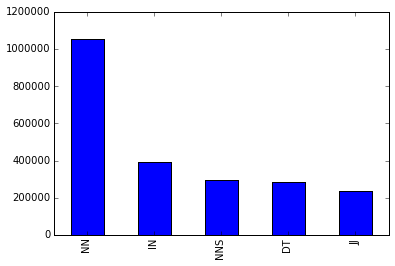

In [136]:
sorted_pos = sorted(tokens_fd.items(), key=itemgetter(1), reverse=True) # sort pos counts
print 'Top 5 Parts of Speech (Question A1)'

# bar graph of top 5 pos and their frequencies
xvar = [x for (x, y) in sorted_pos]
series_plot = pd.Series([y for (x, y) in sorted_pos], index=xvar)
print(series_plot[0:5].plot(kind='bar'))

labels = load('help/tagsets/upenn_tagset.pickle')
dictionary = pd.Series({key:labels[key][0] for key in labels.keys()})
pd.concat([dictionary, series_plot[0:5]], axis=1, join="inner").rename(columns={0:'Description',1:'Count'})

#### A2. Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

In [137]:
top100 = counts.most_common(100)
top100counts = pd.Series([b for (a, b) in list_wordcounts]) # get the frequencies for the top 100 words
top100words = pd.Series([a for (a, b) in list_wordcounts]) # get the top 100 words

In [138]:
index = xrange(1,100)
zipf = []

for i, value in enumerate(top100counts): # calculate Zipf's value
    zipf.append((100000.0/(i+1))) # scaling Zipf's calculation due to difference in magnitude

index = pd.Series(index)
zipf = pd.Series(zipf)
zipf = pd.concat([index, zipf, top100counts], axis=1) # df of word rank, zipf value, and count

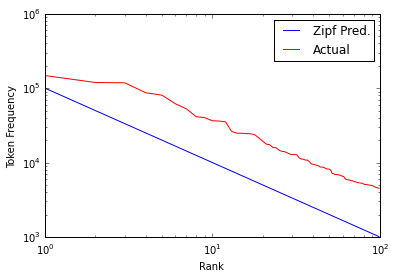

Zipf's law does hold true here because we see an inverse relationship between rank and token frequency.


In [139]:
plt.plot(zipf[[0]], zipf[[1]], 'b-', label='Zipf Pred.')
plt.plot(zipf[[0]], zipf[[2]], 'r-', label='Actual')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Token Frequency')
plt.xscale('log')
plt.legend()
plt.show()

print 'Zipf\'s law does hold true here because we see an inverse relationship between rank and token frequency.'

#### A3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What is their frequency?

Top 10 Words without stop words and lemmatized, what are their frequencies? (Question A3)
experience    24909
work          18196
role          16962
team          16271
client        16129
care          14231
working       13996
service       13729
skill         13173
within        12795
dtype: int64
Axes(0.125,0.125;0.775x0.775)


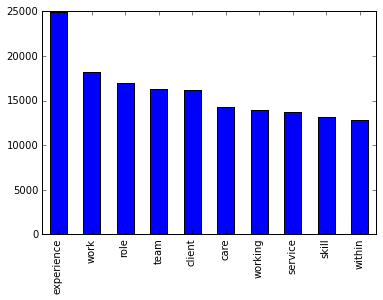

In [78]:
# remove stop words and lemmatize
nostop = [word for word in wordlist if word not in stopwords.words('english')]

lmtzr = WordNetLemmatizer()
nostoplmtzed = [lmtzr.lemmatize(word) for word in nostop]

print('Top 10 Words without stop words and lemmatized')
print(pd.Series(nostoplmtzed).value_counts()[:10])
print(pd.Series(nostoplmtzed).value_counts()[:10].plot(kind='bar'))

##Part B (predict salary from job description)

In this section, you will create classification models to predict high (75th percentile and above) or low (below 75th percentile) salary from the text contained in the job descriptions. Ignore all other data provided on kaggle.com that is not text (except the actual salary data, which you need to create the binary output of high/low salary).    
Get the training data on kaggle.com (train_rev1), divide it randomly into training data (60%) and validation data (40%) to build and validate the model respectively. Do not use the validation data provided on kaggle.com. Use the Naïve Bayes classifier in Python (we will discuss the theory of Naïve Bayes later in this course. There are two versions of Naïve Bayes – binomial and multinomial; for the moment, let’s not bother about the theoretical underpinnings! You can use either one for this assignment). For all models below, show the confusion matrix.

#### B1. Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)?

We ran two different Multinomial Naïve Bayes models: 1) using the random sample of all of the data and 2) using a sample with a 50/50 split of the classes. The reason we used the 50/50 split was to allow our function an equal sample of both classes to train on to achieve better accuracy. The model with the random sample predicted almost all 0's because most of the training data were 0's. Giving the model more 1's to train on should improve performance. Below we see that the equal class model does indeed perform better.

### Classification model with random sample of the data

In [140]:
np.random.seed(1234567)
sample = salary_data.sample(15000, replace=False).copy() # sample the data
salaries = sample['SalaryNormalized']
threshold = np.percentile(salaries, 75) # threshold for dependent variable

In [141]:
sample['High'] = 0.0
high_mask = sample['SalaryNormalized'] >= threshold
sample.ix[high_mask,'High'] = 1

In [142]:
train = sample.sample(0.6*len(sample), replace=False).copy()
test = sample[~sample.index.isin(train.index.values)]

In [143]:
train_x = train['FullDescription']
train_y = train['High']

test_x = test['FullDescription']
test_y = test['High']

In [144]:
vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode', norm='l2')

In [145]:
# function to train, test, and print results for MNB model
def tester (v):
    X_transform = v.fit_transform(train_x)
    X_test = v.transform(test_x)
    
    nb_classifier = MultinomialNB().fit(X_transform, train_y)
    y_nb_predicted = nb_classifier.predict(X_test)
    
    predict_y = Series(y_nb_predicted).reset_index()[0]
    df = pd.DataFrame()
    df['Predicted'] = predict_y
    df['Test'] = test_y.reset_index()['High']
    
    print "Percent Correct\n",round((df['Predicted'] == df['Test']).mean()*100,3)
    print "\nConfusion Matrix\n", pd.crosstab(index=df['Test'], columns=df['Predicted'])
    print "\nProportion Table\n", pd.crosstab(index=df['Test'], columns=df['Predicted']).apply(lambda r: r/r.sum(), axis=1)

In [146]:
tester(vectorizer)

Percent Correct
74.3

Confusion Matrix
Predicted     0   1
Test               
0          4439   2
1          1540  19

Proportion Table
Predicted         0         1
Test                         
0          0.999550  0.000450
1          0.987813  0.012187


###Classification model with equal sized classes

In [164]:
salary_data['High'] = 0.0
high_mask = salary_data['SalaryNormalized'] >= threshold
salary_data.ix[high_mask,'High'] = 1.0

In [165]:
high = salary_data[salary_data['High']==1]
low = salary_data[salary_data['High']!=1]

In [166]:
sample_high = high.sample(7500, replace=False).copy()
sample_low = low.sample(7500, replace=False).copy()
equal_sample = sample_high.append(sample_low, ignore_index=False, verify_integrity=True)

In [167]:
train = equal_sample.sample(0.6*len(equal_sample), replace=False).copy()
test = equal_sample[~equal_sample.index.isin(train.index.values)]

In [168]:
train_x = train['FullDescription']
train_y = train['High']

test_x = test['FullDescription']
test_y = test['High']

In [169]:
tester(vectorizer)

Percent Correct
77.917

Confusion Matrix
Predicted     0     1
Test                 
0          2162   845
1           480  2513

Proportion Table
Predicted         0         1
Test                         
0          0.718989  0.281011
1          0.160374  0.839626


#### B2. Speculate before running the following analysis whether lemmatization would help improve the accuracy of classification. Now create a classification model after lemmatization. Did the classification accuracy increase relative to B1? Comment on your speculation versus the actual results you obtained.

We speculated that lemmatization will improve the accuracy of our model because it reduces noise by grouping similar words together. However, below we find performance to be the same or in some cases somewhat lower. The difference is negligible.

In [153]:
# following scikit documentation to lemmatize
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [154]:
lemma_vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode', norm='l2', tokenizer=LemmaTokenizer())

In [155]:
tester(lemma_vectorizer)

Percent Correct
78.2

Confusion Matrix
Predicted     0     1
Test                 
0          2203   760
1           548  2489

Proportion Table
Predicted         0         1
Test                         
0          0.743503  0.256497
1          0.180441  0.819559


#### B3. If you got better results with lemmatization, retain the lemmatized data, else use the original one. Now speculate whether stopwords removal would help increase the accuracy of the model. Take out the stopwords, build a classification model and check the accuracy, and compare with that in B1 & B2.   

####Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary.

We speculated that removing stop words should improve accuracy because it removes words that are common and uninformative. Running the model without stop words on the 50/50 split dataset without lemmatization did improve accuracy slightly. Below is a summary of the mode with stop words removed.

In [156]:
stop_vectorizer = \
TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode',\
                norm='l2', stop_words="english")

In [157]:
tester(stop_vectorizer)

Percent Correct
78.383

Confusion Matrix
Predicted     0     1
Test                 
0          2170   793
1           504  2533

Proportion Table
Predicted         0         1
Test                         
0          0.732366  0.267634
1          0.165953  0.834047


###Top Ten Words (using Coef)

Below are the top ten words for low and high salaries, respectively. What we did was run 2 models: one for predicting low salaries and one for predicting high salaries, so that we could get the words with the largest coefficients from the Naïve Bayes model. These coefficients tell us which tokens are most indicative of each class.

In [219]:
# low salary words
salary_data['Low'] = 0.0
low_mask = salary_data['SalaryNormalized'] <= threshold
salary_data.ix[low_mask,'Low'] = 1.0

high = salary_data[salary_data['High']==1]
low = salary_data[salary_data['High']!=1]

np.random.seed(1234567)
sample_high = high.sample(7500, replace=False).copy()
sample_low = low.sample(7500, replace=False).copy()
equal_sample = sample_high.append(sample_low, ignore_index=False, verify_integrity=True)

train = equal_sample.sample(0.6*len(equal_sample), replace=False).copy()
test = equal_sample[~equal_sample.index.isin(train.index.values)]

train_xB3 = train['FullDescription']
train_yB3 = train['Low']
test_xB3 = test['FullDescription']
test_yB3 = test['Low']

X_transformB3 =stop_vectorizer.fit_transform(train_xB3)
X_testB3 =stop_vectorizer.transform(test_xB3)

nb_classifierB3 = MultinomialNB().fit(X_transformB3, train_yB3)
y_nb_predictedB3 = nb_classifierB3.predict(X_testB3)

N = 10
vocabulary = np.array([t for t, i in sorted(stop_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
print('Top Ten Words indicative of a low salary')
topNlows = np.argsort(nb_classifierB3.coef_[0])[-N:]
print(" ".join(vocabulary[topNlows]))

# high salary words
train_xB3 = train['FullDescription']
train_yB3 = train['High']
test_xB3 = test['FullDescription']
test_yB3 = test['High']

X_transformB3 = stop_vectorizer.fit_transform(train_xB3)
X_testB3 = stop_vectorizer.transform(test_xB3)

nb_classifierB3 = MultinomialNB().fit(X_transformB3, train_yB3)
y_nb_predictedB3 = nb_classifierB3.predict(X_testB3)

N = 10
vocabulary = np.array([t for t, i in sorted(stop_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
print('\nTop Ten words indicative of a high salary')
bottomNlows = np.argsort(nb_classifierB3.coef_[0])[-N:]
print(" ".join(vocabulary[bottomNlows]))

Top Ten Words indicative of a low salary
company manager working skills team business role work sales experience

Top Ten words indicative of a high salary
design client development team manager role project management experience business


###Top Ten Words (Log Probability Ratio)

Seeing that there was an overlap in the words using the coefficients method described above, we decided to try using log probability ratios to determine the tokens that are likely to be found in one class but not the other. Below are the ten words most indicative of higher and lower salaries using this method. We used the log probability ratio between the high salary class and the low salary class for each token from the Naïve Bayes function in Python. So for example, if we have a token that has a high probability of being in the high class and a low probability of being in the low class, we can say that it is indicative of the high class and vice versa.

In [230]:
stop_vectorizer = \
TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode',\
                norm='l2', stop_words="english")

stop_train_x = stop_vectorizer.fit_transform(train_x)
stop_test_x = stop_vectorizer.transform(test_x)
stop_nb_classifier = MultinomialNB().fit(stop_train_x, train_y)

In [231]:
class0log = stop_nb_classifier.feature_log_prob_[0]
class1log = stop_nb_classifier.feature_log_prob_[1]

class1log_exp = []

for i in class1log:
    class1log_exp.append(math.exp(i))

class0log_exp = []
for j in class0log:
    class0log_exp.append(math.exp(j))

ratio = []
for index, var in enumerate(class1log_exp):
    ratio.append(class0log_exp[index]/var)

vocabulary = np.array([t for t, i in sorted(stop_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])

topN1 = np.argsort(ratio)[-N:]
print('Words most indicative of a lower salary: ')
print(" ".join(vocabulary[topN1]))
bottomN1 = np.argsort(ratio)[:N]
print('\nWords most indicative of a higher salary:')
print(" ".join(vocabulary[bottomN1]))

Words most indicative of a lower salary: 
adecco teaching teachers chef hgv assistant cleaning asbestos sous partie

Words most indicative of a higher salary:
architect locum ruby dynamics architecture ssis scrum emea huxley unified


#### B4. Use the job descriptions without lemmatiztion and stopword removal. Add parts-of-speech bigrams to the bag-of-words, and run a new classification model. Does the accuracy increase over the results in B1?

Below is a confusion matrix showing prediction results using POS Bi-Grams as tokens. The accuracy actually dropped significantly using POS bi-grams. Despite the drop in accuracy, it was impressive we were able to achieve a decent accuracy using just POS Bi-Grams.

Note: We checked with Sam (TA) and he confirmed we should use just POS Bi-Grams for our bag of words.

In [232]:
class posBigram(object):
    def __init__(self):
        pass
    def __call__(self,doc):
      return nltk.Text(nltk.bigrams([i[1] for i in nltk.pos_tag(nltk.word_tokenize(doc))]))

In [233]:
pos_bigram_vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode', norm='l2', tokenizer=posBigram())

In [234]:
pos_bigram_train_x = pos_bigram_vectorizer.fit_transform(train_x)
pos_bigram_nb_classifier = MultinomialNB().fit(pos_bigram_train_x, train_y)

In [235]:
pos_bigram_test_x = pos_bigram_vectorizer.transform(test_x)
pos_bigram_y_nb_predicted = pos_bigram_nb_classifier.predict(pos_bigram_test_x)

In [236]:
pos_bigram_predict_y = Series(pos_bigram_y_nb_predicted).reset_index()
pos_bigram_predict_y = pos_bigram_predict_y[0]
pos_bigram_df = pd.DataFrame()
pos_bigram_df['Predicted'] = pos_bigram_predict_y
pos_bigram_df['Actual'] = test_y.reset_index()['High']
pd.crosstab(index=pos_bigram_df['Actual'], columns=pos_bigram_df['Predicted'])

Predicted,0.0,1.0
Actual,,
0,1779,1228
1,911,2082


In [237]:
(pos_bigram_df['Predicted'] == pos_bigram_df['Actual']).mean()

0.64349999999999996